# Table of Contents
 <p>

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import optimize
from functools import partial

In [51]:
# Variance for M_L mechanism
def varVL(K, g, e, ν2=1):
    '''
    K is the total number of clients.
    g = n / K-n
    e is epsilon (overall dp budget)
    ν2 = 1  # to get an upper-bound of the variance of mechanism L
    '''
    def varL(k, e):
        return 2 * ((k / e)**2)

    if e < 2 / 3:
        e1 = np.log(3) - (e / 2)
        vk = varL(2 / 3, e)
        
    elif e >= 2 / 3:
        e1 = np.log(2 / e) + e - 1
        vk = 2
    el = np.exp(-e1)       
       
    g0 = (1 + g) / g
    g1 = g0 * (1 + g)
    g2 = g0 * (1 + g**3) / g
    
    term1 = el*ν2 + varL(2, e)*(1 + el)
    term2 = vk * (el + el*el)
    
    return (1 / K) * (g1 * term1 + g2 * term2)
varVL_vect = np.vectorize(varVL)


# Variance for M_R mechanism
def varVR(K, g, e, ν2=0):
    '''
    K is the total number of clients.
    g = n / K-n
    beta = alpha = e (epsilon, overall dp budget)
    ν2 = 0  # to get an upper-bound of the variance of mechanism L
    '''
    b = np.exp(e) / (1 + np.exp(e))
    b1 = 2 * b - 1
    
    a = b
    a1 = (1 - a) / a
    
    g0 = (1 + g) / g
    g1 = g0 * (1 + g)
    g2 = g0 * (1 + g**3) / g
    
    d = a * b1 * b1
    term1 = (1 - ν2 * a * b1 * b1) / d
    term2 = ((1 - a) / a) / d
    
    return (1 / K) * (g1 * term1 + g2 * term2)
varVR_vect = np.vectorize(varVR)


# Numerically find the epsilon that satisfies bound alpha
def find_epsilon_for_error(K, alpha, var, g=1):
    prob = 0.01  #  we define prob = 1 / M^2
    def obj(x):
        return (var(K, g, x) / prob) - (alpha**2)
        #return 10 * np.sqrt(var(K, g, x)) - alpha
    sol = optimize.root(obj, 0.000001)
    #print((var(K, g, sol.x[0]) / (alpha**2)) - prob)
    if (var(K, g, sol.x[0]) / prob) - (alpha**2) > 0.01:
        return np.nan
    return sol.x[0]
find_epsilon_for_error_vect = np.vectorize(find_epsilon_for_error)

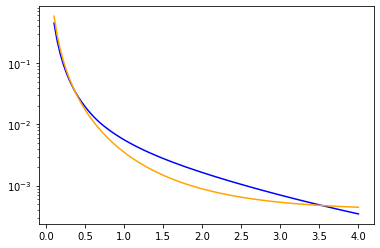

In [57]:
# plot variance graph as a sanity check
xs = np.linspace(0.1, 4, 100)
ax1 = sns.lineplot(x=xs, y =varVL_vect(10000, 1, xs), color='blue')
ax2 = sns.lineplot(x=xs, y =varVR_vect(10000, 1, xs), color='orange')
ax1.set(yscale='log')
ax1.axhline(0)

In [61]:
# we plugin the variance to obtain the Chebyshev bound
1 * np.sqrt(varVR_vect(10000000, 1, np.array([0.01, 0.1, 1, 1.78, 10])))

array([0.2517257 , 0.02411457, 0.00187209, 0.00103896, 0.00063254])

In [62]:
1 * np.sqrt(varVL_vect(10000000, 1, np.array([0.01, 0.1, 1, 1.78, 10])))

array([2.10500417e-01, 2.11920119e-02, 2.36643191e-03, 1.42995122e-03,
       1.80998644e-04])

In [58]:
find_epsilon_for_error_vect(10000000, np.array([0.1048]), varVL)

array([0.20391696])

In [55]:
ni, nf = 5, 9
ns = np.logspace(ni, nf, np.abs(nf - ni) + 1)

ai, af = 1, 3
alphas = np.logspace(-ai, -af, np.abs(af - ai) + 1)

mechanisms = {"$\mathcal M_R$": varVR, "$\mathcal M_L$": varVL}

results, cols = [], []
for name, m in mechanisms.items():
    results_m = []
    for n in ns:
        results_m.append(find_epsilon_for_error_vect(n, alphas, m))
    results.append(np.vstack(results_m))
columns = pd.MultiIndex.from_product((mechanisms, alphas), names=('Mechanism', '$\\alpha$'))
df = pd.DataFrame(np.hstack(results), columns=columns)
df.insert(0, 'K', value=[f"$10^{int(np.log10(x))}$" for x in ns])
df.set_index('K')

Mechanism $\mathcal M_R$                       $\mathcal M_L$             \
$\alpha$           0.100      0.010      0.001          0.100      0.010   
K                                                                          
$10^5$          1.860958  29.782089  30.446822       2.560316  17.888992   
$10^6$          0.632751  34.017666  29.175259       0.714442   6.322309   
$10^7$          0.228162   1.860958  28.597347       0.213885   2.560316   
$10^8$          0.077071   0.632751  35.933029       0.066845   0.714442   
$10^9$          0.024987   0.228162   1.860958       0.021067   0.213885   

Mechanism              
$\alpha$        0.001  
K                      
$10^5$     178.885438  
$10^6$      56.568542  
$10^7$      17.888992  
$10^8$       6.322309  
$10^9$       2.560316

In [56]:
print(df.to_latex(index=False, escape=False, float_format="%.2f").replace('NaN', '-'))

\begin{tabular}{lrrrrrr}
\toprule
      K & \multicolumn{3}{l}{$\mathcal M_R$} & \multicolumn{3}{l}{$\mathcal M_L$} \\
        &            0.1 &  0.01 & 0.001 &            0.1 &  0.01 &  0.001 \\
\midrule
 $10^5$ &           1.86 & 29.78 & 30.45 &           2.56 & 17.89 & 178.89 \\
 $10^6$ &           0.63 & 34.02 & 29.18 &           0.71 &  6.32 &  56.57 \\
 $10^7$ &           0.23 &  1.86 & 28.60 &           0.21 &  2.56 &  17.89 \\
 $10^8$ &           0.08 &  0.63 & 35.93 &           0.07 &  0.71 &   6.32 \\
 $10^9$ &           0.02 &  0.23 &  1.86 &           0.02 &  0.21 &   2.56 \\
\bottomrule
\end{tabular}

